In [1]:
import os
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import re
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras.layers import MaxPooling3D, \
    Input, ConvLSTM2D, UpSampling2D, \
    MaxPooling2D, Conv2D, Concatenate, Conv3D, \
    Dropout, BatchNormalization, Add, MaxPool2D, Conv2DTranspose, MaxPool3D, Conv3DTranspose, UpSampling3D, \
    concatenate, MaxPooling3D, Bidirectional, TimeDistributed 
from tensorflow.python.client import device_lib
import random
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from keras import backend as K 
import neptune
from keras.callbacks import Callback


2021-12-11 10:26:54.794542: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


In [2]:
########################################################################################################################
# Link to neptune ai for monitoring
########################################################################################################################
run = neptune.init(project_qualified_name='abdalraheem.ijjeh/aidd',
                   api_token='hidden')
neptune.create_experiment('Autoencoder final version for paper MSSP3')
neptune.append_tag('Monitoring loss and metrtics for MSSP3 reviewers')

https://app.neptune.ai/abdalraheem.ijjeh/aidd/e/SAN-3331


In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
# print(device_lib.list_local_devices())

In [4]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [5]:
input_dir = "/aijjeh_odroid_sensors/aidd/data/raw/num/wavefield_dataset2_bottom_out/"
target_dir = "/home/aijjeh/Desktop/Phd_Projects/dataset2_labels_out"
my_list = os.listdir(input_dir)
my_list.sort(key=natural_keys)
# print(my_list)

In [6]:
print(len(my_list))

475


In [7]:
height = 512
width =  512
img_size = (height, width)
num_classes = 2
batch_size = 1
time_stamps =  24
num_filters = 24
filter_size = 3
dropout_rate = 0.2
epochs = 100
input_img_paths_total = [None]*380

In [8]:
for i in range(380):
    input_dir = "/aijjeh_odroid_sensors/aidd/data/raw/num/wavefield_dataset2_bottom_out/" +'%d_output' % (i+1) #str(my_list[i])
    input_img_paths = sorted( 
        [
            os.path.join(input_dir, fname) 
            for fname in os.listdir(input_dir)    
            if fname.endswith(".png")
        ] 
    )
    input_img_paths.sort(key=natural_keys)
    input_img_paths_total[i] = input_img_paths
    

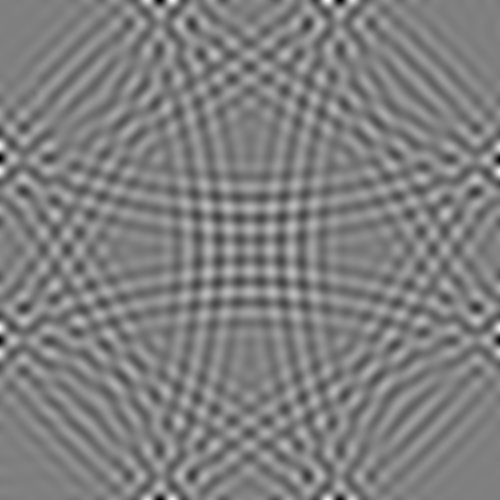

In [9]:
Image(input_img_paths_total[379][511])

In [10]:
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
target_img_paths.sort(key=natural_keys)

In [11]:
print(len(target_img_paths))
# print(target_img_paths)

380


In [12]:
print("Number of samples:", len(input_img_paths_total))

Number of samples: 380


In [13]:
class Full_wavefield_frames(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths_total_, target_img_paths_, time_stamps):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths_total = input_img_paths_total_
        self.target_img_paths = target_img_paths_
        self.time_stamps = time_stamps
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size        
        batch_input_img_paths = self.input_img_paths_total[i:i+self.batch_size]      
        batch_target_img_paths = self.target_img_paths[i:i+self.batch_size] 
        
        x = np.zeros((self.batch_size,) + (self.time_stamps,) + self.img_size + (1,), dtype="float16") #  
        
        for batch_num in range(self.batch_size):
            batch_input_img_paths = batch_input_img_paths[batch_num][file_frame[i]:file_frame[i]+self.time_stamps] 
            for j, path in enumerate(batch_input_img_paths):
                img = load_img(path, target_size=self.img_size, color_mode="grayscale")            
                img = np.expand_dims(img,2)
                img = img / 255.0
                x[batch_num][j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float16")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")            
            img = np.expand_dims(img, 2)
            img = img / 255.0
            y[j] = img
                # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
                # y[j] -= 1
        return x, y

In [14]:
os.chdir('/home/aijjeh/Desktop/Phd_Projects/Sequence_prediction/Full_wavefield_frames_time_series_project/Datasets/label_set')

In [15]:
file_frame = np.load('frames_initial.npy')
file_frame = file_frame[:380]

In [16]:
print(len(file_frame))

380


In [17]:
# Split our img paths into a training and a validation set
val_samples = int(0.20*len(my_list))
# random.Random(1337).shuffle(input_img_paths_total)
# random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths_total[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths_total[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

print(len(train_input_img_paths))

# Instantiate data Sequences for each split
train_gen = Full_wavefield_frames(batch_size, img_size, train_input_img_paths, train_target_img_paths, time_stamps)
val_gen = Full_wavefield_frames(batch_size, img_size, val_input_img_paths, val_target_img_paths, time_stamps)

print(len(train_gen))
print('1st axis',len(train_gen[0]))
print('2nd axis',len(train_gen[0][0]))
print('3rd axis',len(train_gen[0][0][0]))
print('4th axis',len(train_gen[0][0][0][0]))
print('5th axis',len(train_gen[0][0][0][0][0]))
print('6th axis',len(train_gen[0][0][0][0][0][0]))

print(np.shape(train_gen[0][1]))

285
285
1st axis 2
2nd axis 1
3rd axis 24
4th axis 512
5th axis 512
6th axis 1
(1, 512, 512, 1)


In [18]:
def normalize_batch(bn_input):
    return keras.layers.BatchNormalization()(bn_input)

In [19]:
def get_time_distributed(time_input, n_filters):
    x = TimeDistributed(Conv2D(filters=n_filters,
                               kernel_size=(3, 3),
                               strides=1, padding='same',
                               activation='relu'))(time_input)
    return x

In [20]:
def jaccard_index(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac 

In [21]:
def get_model(img_size, num_classes):
    inputs = Input(shape = ((time_stamps,)+ img_size + (1,)))    
    ####################################################################################################################
    c11 = get_time_distributed(inputs, num_filters)
    BN = normalize_batch(c11)
    c12 = get_time_distributed(BN, num_filters)
    BN1 = normalize_batch(c12)
    d1 = TimeDistributed(MaxPool2D((2, 2), strides=(2, 2)))(BN1)
    d1 = keras.layers.Dropout(dropout_rate)(d1)
    ####################################################################################################################
    c21 = get_time_distributed(d1, num_filters*2)
    BN = normalize_batch(c21)
    c22 = get_time_distributed(BN, num_filters*2)
    BN2 = normalize_batch(c22)
    d2 = TimeDistributed(MaxPool2D((2, 2), strides=(2, 2)))(BN2)
    d2 = keras.layers.Dropout(dropout_rate)(d2)
    ####################################################################################################################
    c31 = get_time_distributed(d2, num_filters*3)
    BN = normalize_batch(c31)
    c32 = get_time_distributed(BN, num_filters*3)
    BN3 = normalize_batch(c32)
    d3 = TimeDistributed(MaxPool2D((2, 2), strides=(2, 2)))(BN3)
    d3 = keras.layers.Dropout(dropout_rate)(d3)
    ####################################################################################################################
    c41 = get_time_distributed(d3, num_filters*4)
    BN = normalize_batch(c41)
    c42 = get_time_distributed(BN, num_filters*4)
    BN4 = normalize_batch(c42)
    d4 = TimeDistributed(MaxPool2D((2, 2), strides=(2, 2)))(BN4)
    d4 = keras.layers.Dropout(dropout_rate)(d4)
    ####################################################################################################################
    # bottleneck layer
    ##################################################################################################
    c51 = get_time_distributed(d4, num_filters*5)
    BN = normalize_batch(c51)
    c52 = get_time_distributed(BN, num_filters*5)
    BN = normalize_batch(c52)
    ####################################################################################################################
    # Up sampling convolution followed by ConvTranspose
    ####################################################################################################################
    u1 = TimeDistributed(UpSampling2D((2, 2)))(BN)
    skip4 = concatenate([BN4, u1])
    skip4 = keras.layers.Dropout(dropout_rate)(skip4)  # adding dropout layer
    c61 = get_time_distributed(skip4, num_filters*4)
    BN = normalize_batch(c61)
    c62 = get_time_distributed(BN, num_filters*4)
    BN = normalize_batch(c62)
    ####################################################################################################################
    u2 = TimeDistributed(UpSampling2D((2, 2)))(BN)
    skip3 = concatenate([BN3, u2])
    skip3 = keras.layers.Dropout(dropout_rate)(skip3)
    c71 = get_time_distributed(skip3, num_filters*3)
    BN = normalize_batch(c71)
    c72 = get_time_distributed(BN, num_filters*3)
    BN = normalize_batch(c72)
    ####################################################################################################################
    u3 = TimeDistributed(UpSampling2D((2, 2)))(BN)
    skip2 = concatenate([BN2, u3])
    skip2 = keras.layers.Dropout(dropout_rate)(skip2)
    c81 = get_time_distributed(skip2, num_filters*2)
    BN = normalize_batch(c81)
    c82 = get_time_distributed(BN, num_filters*2)
    BN = normalize_batch(c82)
    ####################################################################################################################
    u4 = TimeDistributed(UpSampling2D((2, 2)))(BN)
    skip1 = concatenate([BN1, u4])
    skip1 = keras.layers.Dropout(dropout_rate)(skip1)
    c91 = get_time_distributed(skip1, num_filters)
    BN = normalize_batch(c91)
    c92 = get_time_distributed(BN, num_filters)
    BN = normalize_batch(c92)
    ####################################################################################################################
    lstm_layer = ConvLSTM2D(24, (3, 3), padding='same', return_sequences=False)(BN)
    ####################################################################################################################
    # Output layer
    output = Conv2D(1, (1, 1), activation='sigmoid')(lstm_layer)
    #################################################################################################################### 
    model_ = Model(inputs=inputs, outputs=output)
    ####################################################################################################################
    return model_
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

2021-12-11 10:27:16.495181: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-11 10:27:16.497246: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-11 10:27:16.534028: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:86:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2021-12-11 10:27:16.534072: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-11 10:27:16.537994: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-12-11 10:27:16.538087: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 512, 512 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 24, 512, 512, 240         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 512, 512, 96          time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 24, 512, 512, 5208        batch_normalization[0][0]        
______________________________________________________________________________________________

/aijjeh_odroid_sensors/aidd/data/raw/num/wavefield_dataset2_bottom_out/1_output/1_flat_shell_Vz_1_500x500bottom.png


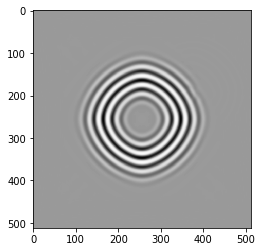

(24, 512, 512, 1)

In [22]:
print(train_input_img_paths[0][0])
img = train_gen[0][0][0]
plt.imshow((img[0]*255).astype(np.uint8), cmap='Greys')
plt.show()
display(img.shape)


In [23]:
def get_jaccard_index(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [24]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[get_jaccard_index])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation_%d_version_10_12_2021.h5" % time_stamps, save_best_only=True)
]
class MonitoringCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        for metric_name, metric_value in logs.items():
            neptune.log_metric(metric_name, metric_value)


# Train the model, doing validation at the end of each epoch.
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=[MonitoringCallback(), callbacks])  # 

os.chdir('/home/aijjeh/Desktop/Phd_Projects/Sequence_prediction/Sequence_to_sequence/h5_models/')
model.save("UNet_Xception_style_model_%d_version_10_12_2021.h5" % time_stamps )

2021-12-11 10:27:19.772231: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-11 10:27:19.773280: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/100


2021-12-11 10:27:27.395115: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-12-11 10:27:29.441694: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-12-11 10:27:29.845718: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-12-11 10:27:32.307324: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-11 10:27:32.307416: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performan

285/285 [==============================] - 324s 1s/step - loss: 0.0672 - get_jaccard_index: 0.9627 - val_loss: 0.0148 - val_get_jaccard_index: 0.9980
Epoch 2/100
285/285 [==============================] - 309s 1s/step - loss: 0.0109 - get_jaccard_index: 0.9970 - val_loss: 0.0170 - val_get_jaccard_index: 0.9963
Epoch 3/100
285/285 [==============================] - 313s 1s/step - loss: 0.0073 - get_jaccard_index: 0.9979 - val_loss: 0.1687 - val_get_jaccard_index: 0.8835
Epoch 4/100
285/285 [==============================] - 309s 1s/step - loss: 0.0037 - get_jaccard_index: 0.9985 - val_loss: 0.0140 - val_get_jaccard_index: 0.9988
Epoch 5/100
285/285 [==============================] - 309s 1s/step - loss: 0.0029 - get_jaccard_index: 0.9988 - val_loss: 0.0145 - val_get_jaccard_index: 0.9989
Epoch 6/100
285/285 [==============================] - 312s 1s/step - loss: 0.0025 - get_jaccard_index: 0.9990 - val_loss: 0.0158 - val_get_jaccard_index: 0.9974
Epoch 7/100
285/285 [===================

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/PhD_clone_env/lib/python3.7/site-packages/urllib3/connectionpool.py", line 706, in urlopen
    chunked=chunked,
  File "/usr/local/anaconda3/envs/PhD_clone_env/lib/python3.7/site-packages/urllib3/connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/usr/local/anaconda3/envs/PhD_clone_env/lib/python3.7/site-packages/urllib3/connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "/usr/local/anaconda3/envs/PhD_clone_env/lib/python3.7/http/client.py", line 1369, in getresponse
    response.begin()
  File "/usr/local/anaconda3/envs/PhD_clone_env/lib/python3.7/http/client.py", line 310, in begin
    version, status, reason = self._read_status()
  File "/usr/local/anaconda3/envs/PhD_clone_env/lib/python3.7/http/client.py", line 271, in _read_status
    line = str(self.fp.readline(_M